In [362]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import copy
from tqdm import tqdm

In [363]:
dt=0.1
t=np.arange(0.,10.,dt)

In [ ]:
class Layer:
    
    
    def __init__(self,NC,NN,ActFun,rate=0.2): # Jugar con la tasa de mutacion
        
        self.NC = NC
        self.NN = NN
        self.ActFunc = ActFun
        self.rate = rate
        
        
        self.W = np.random.uniform( -10.,10.,(self.NC,self.NN) )
        self.b = np.random.uniform( -10.,10.,(1,self.NN) )
        
    def Activation(self,x):
        z = np.dot(x,self.W) + self.b
        return self.ActFunc( z )[0]
    
    def Mutate(self):
    
        #self.W += np.random.normal( loc=0., scale=self.rate, size=(self.NC,self.NN))
        #self.b += np.random.normal( loc=0., scale=self.rate, size=(1,self.NN))
        
        self.W += np.random.uniform( -self.rate, self.rate, size=(self.NC,self.NN))
        self.b += np.random.uniform( -self.rate, self.rate, size=(1,self.NN))

In [365]:
sigm = lambda x: 1/(1+np.exp(-x))

In [366]:
def GetBrain():
    l0 = Layer(1,5,sigm)
    l1= Layer(5,5,sigm)
    l2= Layer(5,1,sigm)
    
    Brain = [l0,l1,l2]
    return Brain  

In [412]:
class Robot:
    
    def __init__(self, dt, Layers, Id=0):
        
        self.Id = Id
        self.dt = dt
        
        
        self.r = np.random.uniform([0.,0.])
        self.v = np.array([1.,0])

        
        # Capacidad o aptitud del individuo
        self.Fitness = np.inf
        self.Steps = 0

        # Brain
        self.Layers = Layers
        
    def GetR(self):
        return self.r
    
    def Evolution(self):
        self.r += self.v*self.dt # Euler integration (Metodos 2)

        # Cada generación regreamos el robot al origin
        # Y volvemos a estimar su fitness
    def Reset(self):
        self.Steps = 0.
        self.r = np.array([0.,0.])
        self.Fitness = np.inf    
        
    # Aca debes definir que es mejorar en tu proceso evolutivo
    def SetFitness(self):
        self.Fitness = 1/self.Steps
        # Esto no hace nada por ahora
        
        
       # Brain stuff
    def BrainActivation(self,x,threshold=0.7): 
        # El umbral (threshold) cerebral es a tu gusto!
        # cercano a 1 es exigente
        # cercano a 0 es sindrome de down
        
        # Forward pass - la infomación fluye por el modelo hacia adelante
        for i in range(len(self.Layers)):         
            if i == 0:
                output = self.Layers[i].Activation(x)
            else:
                output = self.Layers[i].Activation(output)
        
        self.Activation = np.round(output,4)
    
        # Cambiamos el vector velocidad
        if self.Activation[0] > threshold:
            self.v = -self.v
            self.Steps-=0.4
            
            # Deberias penalizar de alguna forma, dado que mucha activación es desgastante!
            # Para cualquier cerebro
    
        return self.Activation
    
    # Aca mutamos (cambiar de parametros) para poder "aprender"
    def Mutate(self):
        for i in range(len(self.Layers)):
            self.Layers[i].Mutate()
    
    # Devolvemos la red neuronal ya entrenada
    def GetBrain(self):
        return self.Layers

In [368]:
def GetRobots(N):
    
    Robots = []
    
    for i in range(N):
        
        Brain = GetBrain()
        r = Robot(dt,Brain,Id=i)
        Robots.append(r)
        
    return Robots

In [369]:
Robots=GetRobots(200)

In [370]:
def GetPlot():
    
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(1,2,1)
    ax1 = fig.add_subplot(1,2,2)
    
    ax.set_xlim(-1.,1.)
    ax.set_ylim(-1.,1.)
 
    return ax,ax1


In [ ]:
def TimeEvolution(Robots,e,Plot=True):
    
  
    for it in range(t.shape[0]):
        
        if Plot:
        
            clear_output(wait=True)
        
            ax,ax1 = GetPlot()
            ax1.set_ylim(0.,1.)
        
            ax.set_title('t = {:.3f}'.format(t[it]))
        
        Activation = np.zeros(len(Robots))
        
        for i,p in enumerate(Robots):
            if -1<p.GetR()[0]<1:
                p.Steps+=0.4
            p.Evolution()
            #Acá va el self.steps if está entre -1 y 1 aumentar el paso
            
         
            # Activacion cerebral
            Act = p.BrainActivation(p.GetR()[0])
            Activation[i] = Act
            # Region donde aumentamos los pasos para el fitness
            
                
            if Plot and i < 5: # Solo pintamos los primeros 5, por tiempo de computo
                ax.scatter(p.r[0],p.r[1],label='Id: {}, Steps: {:.0f}'.format(p.Id,p.Steps))
                ax.quiver(p.r[0],p.r[1],p.v[0],p.v[1])
                
        # Pintamos la activaciones de los primeros 5
        
        if Plot:
            ax1.plot(np.arange(0,len(Robots[:5]),1),Activation[:5],marker='o',color='b',label='Activation')
            ax1.axhline(y=0.7,color='r')
        
        if Plot:
        
            ax.legend(loc=0)  
            ax1.legend(loc=0)
            plt.show()
            time.sleep(0.001)

In [372]:
# Definimos la rutina de entrenamiento
def Genetic(Robots, epochs = 200, Plot = True, Plottime=False):
    
    # Porcentaje de robots elegidos en cada epoch
    N = int(0.7*len(Robots))
    
    FitVector = np.array([])
    
    
    x = np.linspace(-1,1,20)
    Act = np.zeros_like(x)
    
    for e in range(int(epochs)):
        
        # Reiniciamos y mutamos los pesos
        
        for p in Robots:
            p.Reset() 
            p.Mutate()
            
        # Evolucionamos
        TimeEvolution(Robots,e,Plottime) # Apagar dibujar la evolución para entrenar
        
        # Actualizamos fitness de cada robot
        Fitnesses=[]
        for i,p in enumerate(Robots):
            p.SetFitness()
            fitness_p = p.Fitness
            
            Fitnesses.append(fitness_p)

     
        Fitnesses_ordenada=sorted(Fitnesses,reverse=False)
            
        
        # Aca va toda la rutina de ordenar los bots del más apto al menos apto
        
        
        # Guardamos el mejor fitness y le mejor robot
        best_fitness = Fitnesses_ordenada[0]
        Mejor_indice= Fitnesses.index(best_fitness)

        best_bot = Robots[Mejor_indice] #Esto no es asi, deben ver como se elige al mejor
        
        FitVector = np.append(FitVector,best_fitness)
        
        for i in range(len(x)):
            Act[i] = best_bot.BrainActivation(x[i])
        
        clear_output(wait=True)
        
        print('Epoch:', e)
                
        # Last fitness
        print('Last Fitness:', FitVector[-1])
        
        
        if Plot:
            
            ax,ax1 = GetPlot()
            ax.plot(x,Act,color='k')
            ax.set_ylim(0.,1)
            ax.axhline(y=0.75,ls='--',color='r',label='Threshold')
            
            ax1.set_title('Fitness')
            ax1.plot(FitVector)
        
            ax.legend(loc=0)
            
            plt.show()
            
            time.sleep(0.01)
        
        
    
    return best_bot, FitVector

Epoch: 199
Last Fitness: 0.05319148936170211


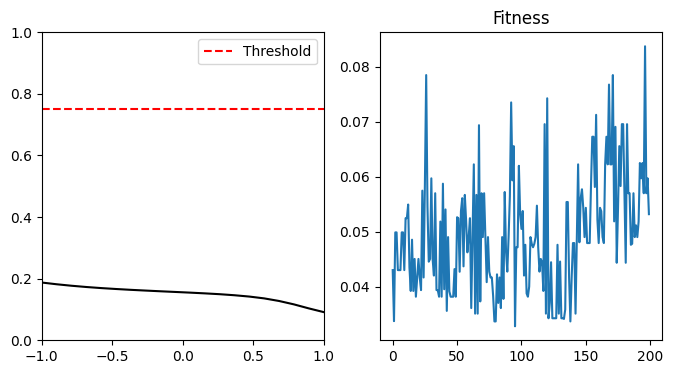

In [414]:
Robots = GetRobots(200)
Best, FitVector = Genetic(Robots,Plot=True,Plottime=False) # Apagar Plottime para el entrenamiento

In [415]:
bestBrain=Best.GetBrain()
Weights=bestBrain[0].W
Biasses=bestBrain[0].b
Weights1=bestBrain[1].W
Biasses1=bestBrain[1].b
Weights2=bestBrain[2].W
Biasses2=bestBrain[2].b

print(Weights,Weights1,Weights2)
Weights,Weights1,Weights2


[[ 5.71561266  2.29157467 -1.01842899  2.23572668  1.52704363]] [[10.00882034  2.95206008  3.84597731 -1.58615788 -9.3355594 ]
 [-8.13264809 -5.29634768  4.56705106  8.92456505  4.36984163]
 [-6.07883973 -8.17261472 -8.27409698 -8.85550152  1.61317497]
 [-9.26651396 -4.58635839  9.78716178 -3.02017103  7.31553769]
 [10.44847492 -5.49549423 -4.39803154 -3.0318922  -7.66540483]] [[ 5.20349134]
 [-1.66739174]
 [-1.53988352]
 [-7.33409704]
 [ 8.49850587]]


(array([[ 5.71561266,  2.29157467, -1.01842899,  2.23572668,  1.52704363]]),
 array([[10.00882034,  2.95206008,  3.84597731, -1.58615788, -9.3355594 ],
        [-8.13264809, -5.29634768,  4.56705106,  8.92456505,  4.36984163],
        [-6.07883973, -8.17261472, -8.27409698, -8.85550152,  1.61317497],
        [-9.26651396, -4.58635839,  9.78716178, -3.02017103,  7.31553769],
        [10.44847492, -5.49549423, -4.39803154, -3.0318922 , -7.66540483]]),
 array([[ 5.20349134],
        [-1.66739174],
        [-1.53988352],
        [-7.33409704],
        [ 8.49850587]]))

Estos valores no corresponden a los Weights encontrados porque corrí sin querer el código luego de hacer todo, el cerebro cambió y no lo podré recuperar. (Había copiado los pesos entrenados gracias a dios). Los valores de Pesos y Biasses que encontramos se encuentran en el Notebook titulado Parcial_4CerebroEntrenadoResultadoFinal